<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/cnn_amber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout
from keras.layers import Flatten

In [51]:
img_rows = 320
img_cols = 320
epochs = 30
batch_size = 22
num_of_train_samples = 1265
num_of_test_samples = 405
num_of_val_samples = 200

In [52]:
#part2-fitting the cnn to the images
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [53]:
# Generating images for the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
# Creating training set
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Amber_yolo/train',
                                                 target_size = (img_rows, img_cols),
                                                 batch_size = batch_size,
                                                 shuffle = True,
                                                 class_mode = 'sparse')
# Creating the Test set
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Amber_yolo/test',
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'sparse')

# Creating the Test set
valid_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Amber_yolo/val',
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'sparse')

Found 1265 images belonging to 20 classes.
Found 504 images belonging to 20 classes.
Found 200 images belonging to 20 classes.


In [60]:
# Making Sppnet custom layer
# Try refering github implementation
# Refer https://keras.io/layers/writing-your-own-keras-layers/
# or https://keras.io/examples/antirectifier/
import sys
from keras.layers import Layer
from keras import backend as K

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

BATCH = 20

class SppnetLayer(Layer):
    '''This layer takes an input tensor and pools the tensor
      in local spatial bins.
      This layer uses Max pooling.
      It accepts input in tensorflow format. # channels last

    # Input
        list of filter in form [x,y,z] 
    # Input shape : 4d tensor [None, X,Y, channels]
    # Output shape : 3d tensor [None,pooled dim, channels] 

    '''
    def __init__(self, filters = [1], **kwargs):
        self.filters = filters
        super(SppnetLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        length = 0;
        for f_size in self.filters:
            length+= (f_size*f_size)
        return (input_shape[0],length*input_shape[3])
      
    def get_config(self):
        config = {'filters': self.filters}
        base_config = super(SppnetLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
      output = []
      for f_size in self.filters:
        win_size = K.int_shape(inputs)[1]/f_size
        #print(win_size)
        win_size = int(win_size)
        for x_start in range(0,f_size):
          for y_start in range(0,f_size):
            X = int(x_start*win_size)
            Y = int(y_start*win_size)
            result = K.max(inputs[:,X:X+win_size,Y:Y+win_size,:],axis = (1,2))
            output.append(result)
      output = K.concatenate(output)
      return output

In [61]:
model=Sequential()

model.add(Conv2D(8,(5,5),activation='relu',input_shape=(img_rows,img_cols,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(8,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(8,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Dropout(0.15))

model.add(SppnetLayer([1,2,4])) #To implement SppNet 
#model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(20,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

print(model.summary())


In [55]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.8,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [62]:
history = model.fit_generator(training_set,epochs=epochs, validation_data=test_set)

<ipython-input-62-33c886a2a3a8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_set,epochs=epochs, validation_data=test_set)


Epoch 1/30
58/58 [==============================] - 53s 877ms/step - loss: 3.0635 - accuracy: 0.0957 - val_loss: 3.1534 - val_accuracy: 0.0417
Epoch 2/30
58/58 [==============================] - 52s 891ms/step - loss: 2.5885 - accuracy: 0.1787 - val_loss: 3.1843 - val_accuracy: 0.0476
Epoch 3/30
58/58 [==============================] - 49s 845ms/step - loss: 2.4178 - accuracy: 0.2316 - val_loss: 3.2015 - val_accuracy: 0.0595
Epoch 4/30
58/58 [==============================] - 68s 1s/step - loss: 2.2531 - accuracy: 0.2846 - val_loss: 3.1132 - val_accuracy: 0.1012
Epoch 5/30
58/58 [==============================] - 54s 927ms/step - loss: 2.1242 - accuracy: 0.3328 - val_loss: 2.9806 - val_accuracy: 0.1052
Epoch 6/30
58/58 [==============================] - 51s 885ms/step - loss: 2.0272 - accuracy: 0.3644 - val_loss: 3.0387 - val_accuracy: 0.1468
Epoch 7/30
58/58 [==============================] - 50s 867ms/step - loss: 1.9577 - accuracy: 0.3802 - val_loss: 3.0849 - val_accuracy: 0.1667
Ep

In [63]:
#AlexNet Inmplementation with batch normalization layers
model1 = Sequential()
model1.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same',activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same',activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same',activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same',activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',activation = 'relu'))
model1.add(BatchNormalization())
model1.add(Flatten()) # To implement Simple Alexnet

model1.add(Dense(4096,activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(4096,activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(20,activation= 'sigmoid'))
model1.compile(loss='sparse_categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_45 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_35 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 13, 13, 256)      0         
 g2D)                                                            
                                                     

In [ ]:
history = model1.fit_generator(training_set,epochs=epochs, validation_data=test_set)

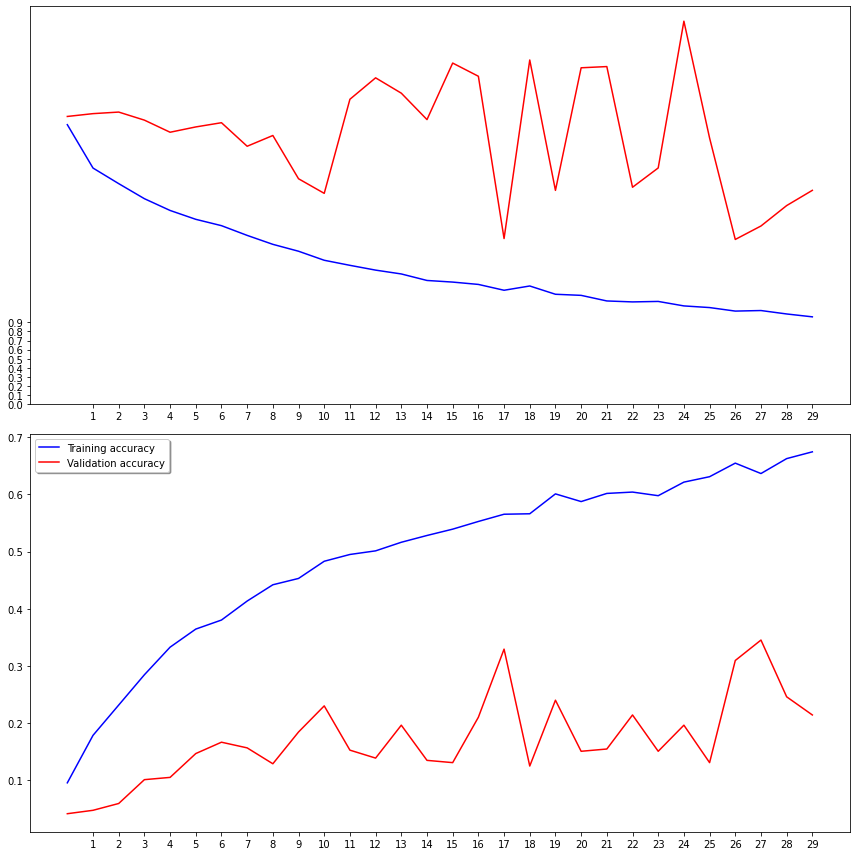

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Amber_yolo/model1_amber150epoch.h5")

In [65]:
y_pred = model.predict_generator(test_set)

<ipython-input-65-76f5f3201beb>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_set)


In [66]:
y_pred 

array([[7.9990132e-03, 1.7501364e-03, 7.1661797e-04, ..., 5.0371397e-02,
        7.4586645e-03, 1.3699338e-01],
       [5.0940169e-03, 1.6268378e-04, 1.5762501e-04, ..., 4.8523270e-02,
        6.0706884e-02, 5.6405586e-01],
       [4.1546896e-03, 4.1916072e-03, 6.0117646e-04, ..., 1.2364240e-02,
        1.6303852e-03, 1.4231089e-02],
       ...,
       [1.6119840e-03, 5.2877422e-02, 1.4804432e-02, ..., 3.5531051e-05,
        5.5577868e-05, 7.7317141e-05],
       [2.4263214e-04, 2.4344500e-03, 1.3323843e-05, ..., 1.4815456e-04,
        1.4825958e-04, 1.2227334e-03],
       [1.3638856e-05, 9.2621100e-05, 5.6149037e-07, ..., 3.4600864e-05,
        8.2684222e-05, 4.5886796e-04]], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['N01', 'N02', 'N03','N04','N05','N06','N07','N08','N09','N10','N11','N12','N13','N14','N15','N16','N17','N18','N19','N20']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 0  0  0  3  4  0  0  0  2  0  2  0  0  5  9  1  2  0  0  4]
 [ 0  0  0  5  4  0  0  1  0  0  1  0  0  7  8  0  1  0  0  7]
 [ 0  0  0  3  6  1  0  0  1  0  0  1  0  7 10  1  0  0  0  2]
 [ 0  0  0  3  2  0  0  0  0  0  1  0  0  6 11  2  1  0  0  1]
 [ 0  1  0  1  4  1  1  0  0  0  2  0  0  8  6  2  3  0  0  1]
 [ 0  0  0  3  3  0  0  0  1  0  5  0  0  5  8  1  0  0  0  2]
 [ 0  1  0  0  6  0  1  0  0  0  1  0  0  5 10  2  0  0  0  3]
 [ 0  0  0  2  8  0  0  0  0  0  3  0  0  3  8  2  0  0  0  0]
 [ 0  0  0  2  2  0  0  0  1  0  1  0  0  7  8  1  2  0  0  2]
 [ 0  1  0  1  4  0  0  0  0  0  0  0  0  3  3  0  1  0  0  2]
 [ 0  0  0  1  2  0  0  0  0  0  1  0  0  3  5  0  1  0  0  2]
 [ 0  1  0  2  3  0  0  0  0  0  1  0  0  2  3  1  0  0  0  1]
 [ 0  0  0  1  3  0  0  0  0  0  1  0  0  3  4  1  1  0  0  0]
 [ 0  1  0  5  5  1  0  0  0  0  1  0  0  8 14  3  2  0  0  4]
 [ 0  0  0  1  3  0  0  0  1  0  1  0  0  7  6  2  0  0  0  2]
 [ 0  1  0  1  2  0  0  1  0  0  2  0 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
